# Deploy SDXL to SageMaker inference endpoint using TorchServe DLC

* Example demonstrates how to deploy SDXL base+refiner models with LoRA on SageMaker
* You can deploy other customized SDXL model rather than base model without compressing model, example can be found [here]()
* Inference DLC uses DLC cateogry [SageMaker Framework Containers - PyTorch 2.0.1](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#sagemaker-framework-containers-sm-support-only) container
* Inference endpoint instance uses ml.g5.2xlarge 

## 1. Custom "inference.py" and "requirements.txt" files for deployment

In [1]:
!mkdir -p ./model/code

In [ ]:
%%writefile ./model/code/requirements.txt
diffusers>=0.19.3
transformers
accelerate
safetensors
invisible_watermark

In [ ]:
%%writefile ./model/code/inference.py
import base64
import torch
import boto3
import json
import os
from botocore.exceptions import ClientError
from io import BytesIO
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

s3 = boto3.client('s3')

def check_file_existence(s3_path):
    bucket_name = s3_path.split("//")[1].split("/")[0]
    object_key = "/".join(s3_path.split("//")[1].split("/")[1:])
    try:
        s3.head_object(Bucket=bucket_name, Key=object_key)
        return True
    except ClientError as e:
        if e.response['Error']['Code'] == '404':
            return False
        else:
            raise

def download_file(s3_path):
    file_path = os.path.join("/tmp/", os.path.basename(s3_path))
    if os.path.exists(file_path):
        print("LoRA file already exists locally. Skipping download.")
        return file_path
    if check_file_existence(s3_path):
        bucket_name = s3_path.split("//")[1].split("/")[0]
        object_key = "/".join(s3_path.split("//")[1].split("/")[1:])
        s3.download_file(bucket_name, object_key, file_path)
        return file_path
    else:
        raise ValueError('LoRA file does not exist. Upload files to S3 first!')

def model_fn(model_dir):
    base_model = "stabilityai/stable-diffusion-xl-base-1.0"
    base_pipe = DiffusionPipeline.from_pretrained(
        base_model,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        cache_dir="/tmp/",
    ).to("cuda")
    # We use “DPM++ 2M Karras” scheduler here, you can choose whatever you want
    base_pipe.scheduler = DPMSolverMultistepScheduler.from_config(
        base_pipe.scheduler.config, 
        use_karras_sigmas=True
    )
    return base_pipe

def input_fn(request_body, request_content_type):
    input_data = json.loads(request_body) # Deserialize input data
    return input_data

def encode_image(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    encoded_image_response = base64.b64encode(buffered.getvalue()).decode()
    return encoded_image_response

def predict_fn(data, base_pipe):
    generator = torch.Generator(device="cuda")
    use_refiner = data.pop("refiner", "")
    high_noise_frac = data.pop("high_noise_frac", 0.8)
    prompt = data.pop("prompt", "")
    negative_prompt = data.pop("negative_prompt", "")
    height = data.pop("height", 1024)
    width = data.pop("width", 1024)
    num_inference_steps = data.pop("num_inference_steps", 20)
    guidance_scale = data.pop("guidance_scale", 7)
    num_images_per_prompt = data.pop("num_images_per_prompt", 2)
    seed = data.pop("seed", "")
    lora_s3_path = data.pop("lora_s3_path", "")

    seeds = []
    encoded_images = []

    if seed:
        seeds = [seed + i for i in range(num_images_per_prompt)]
    else:
        seeds = [generator.seed() for _ in range(num_images_per_prompt)]

    for current_seed in seeds:
        generator.manual_seed(current_seed)
        base_pipe = base_pipe
        if lora_s3_path:
            lora_weight_path = download_file(lora_s3_path)
            base_pipe.load_lora_weights(lora_weight_path, low_cpu_mem_usage=True)
        else:
            base_pipe.unload_lora_weights()
        if use_refiner == "enable":
            notification = "SDXL refiner model is enabled!"
            refiner_model = "stabilityai/stable-diffusion-xl-refiner-1.0"
            refiner_pipe = DiffusionPipeline.from_pretrained(
                refiner_model,
                text_encoder_2=base_pipe.text_encoder_2,
                vae=base_pipe.vae,
                torch_dtype=torch.float16,
                use_safetensors=True,
                variant="fp16",
                cache_dir="/tmp/",
            ).to("cuda")    
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                denoising_end=high_noise_frac,
                generator=generator,
                output_type="latent",
            ).images
            generated_images = refiner_pipe(
                prompt=prompt,
                num_inference_steps=num_inference_steps,
                denoising_start=high_noise_frac,
                image=generated_images,
            ).images[0]
        else:
            notification = "SDXL refiner model is disabled!"
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator
            ).images[0]
            
        encoded_image_rt = encode_image(generated_images)
        encoded_images.append(encoded_image_rt)

    return {"notification": notification, "generated_images": encoded_images, "seeds": seeds}

## 2. Initialize SageMaker for deployment

In [4]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session._region_name
account_id = sagemaker_session.account_id()
sagemaker_client = boto3.client('sagemaker')

In [5]:
from sagemaker.utils import name_from_base
from sagemaker import image_uris

endpoint_name = name_from_base(f"sdxl")
inference_image_uri = image_uris.retrieve(
    framework="pytorch",
    region=region,
    py_version="py310",
    image_scope="inference",
    version="2.0.1",
    instance_type="ml.g5.2xlarge"
)

In [ ]:
from huggingface_hub import snapshot_download
from sagemaker.s3 import S3Uploader

# Supposed you download LoRaA from HF.
local_dir = './model'
snapshot_download(
    repo_id="terrificdm/immature-lora", # We used a self-trained LoRA as a example 
    allow_patterns="*.safetensors",
    local_dir=local_dir,
    local_dir_use_symlinks=False)

# Upload deployment scripts and LoRA weight which you want to deploy to S3.
s3_model_uri=S3Uploader.upload(local_path='./model', desired_s3_uri=f"s3://{bucket}/model2deploy") + '/'
lora_s3_path=s3_model_uri+'immature-lora.safetensors'
print("\nYour LoRA model and deployment scripts are located in s3_model_uri =", s3_model_uri)
print("\nYour LoRA model s3 path is lora_s3_path =", lora_s3_path)

## Create and deploy model for inference

In [ ]:
# We use boto3 sdk to create model, since it supports deployment with uncompressed model files

create_model_response = sagemaker_client.create_model(
    ModelName = endpoint_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        "Image": inference_image_uri,
        "ModelDataSource": {
            "S3DataSource": {
                "S3Uri": s3_model_uri,
                "S3DataType": "S3Prefix",
                "CompressionType": "None"
            }
        }
    }
)

create_endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName = endpoint_name,
    ProductionVariants = [{
        "ModelName": endpoint_name,
        "VariantName": "sdxl",
        "InitialInstanceCount": 1,
        "InstanceType": "ml.g5.2xlarge",
    }]
)

deploy_model_response = sagemaker_client.create_endpoint(
    EndpointName = endpoint_name,
    EndpointConfigName = endpoint_name
)
    
print('Waiting for the endpoint to be in service, this can take several minutes...')
waiter = sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)
print(f'Endpoint {endpoint_name} is in service.')

In [8]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# Create a predictor with proper serializers
predictor = Predictor(
    endpoint_name=endpoint_name, 
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

In [9]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)


Notification: SDXL refiner model is enabled!



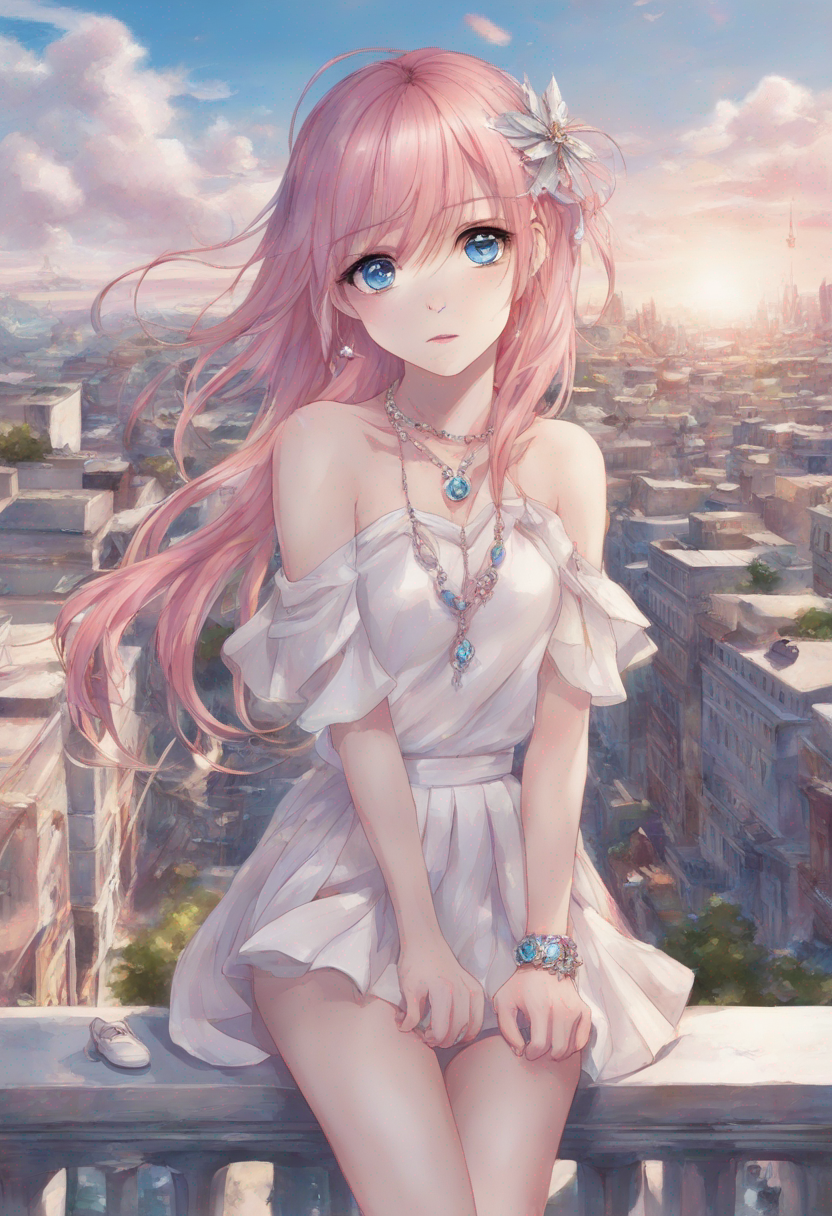


Seeds for generating images: [2243221490029453]


In [29]:
# run prediction
response = predictor.predict(data={
    "prompt": "1girl, standing, blue eyes, parted lips, long hair, pink hair, bangs, jewelry, bare shoulder, skirt, beautiful legs, white shoes, looking at viewer, full body, solo, city background",
    "negative_prompt": "ugly, disfigured, distorted body, bad hands",
    "height": 1216,
    "width": 832,
    "num_images_per_prompt": 1,
    "refiner": "enable",
    "num_inference_steps": 20,
    "high_noise_frac": 0.8,
    "guidance_scale": 7.5,
    "lora_s3_path": lora_s3_path, # You can change s3 url of the lora model in dynamic
    # "seed" : 2243221490029453  # uncomment seed and replace with generated one, if you want to produce same
  }
)

print(f"\nNotification: {response['notification']}\n")

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    
# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")